In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=218e3725bb7ab2dc8830ca1b469af6209d909ef41e6997e490c1f0cf6aaa2943
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def prepare_data_with_dim_reduction(features, target, method="pca", n_components=None, sequence_length=30):
    """
    Prepares LSTM sequences after applying PCA or FDA for dimensionality reduction.

    Parameters:
        features (numpy.ndarray): Scaled feature matrix.
        target (numpy.ndarray): Target array (rise/fall labels).
        method (str): Dimensionality reduction method ("pca" or "fda").
        n_components (int): Number of components to retain (for PCA only).
        sequence_length (int): Number of past days to include in each LSTM sequence.

    Returns:
        X (numpy.ndarray): LSTM input sequences.
        y (numpy.ndarray): LSTM target values.
    """
    if method == "pca":
        # Apply PCA
        pca = PCA(n_components=n_components)  # If n_components is None, PCA decides
        reduced_features = pca.fit_transform(features)
        print(f"PCA: Retained {pca.n_components_} components explaining {sum(pca.explained_variance_ratio_):.2%} of variance.")

    elif method == "fda":
        # Apply Fisher Discriminant Analysis
        fda = LinearDiscriminantAnalysis()
        reduced_features = fda.fit_transform(features, target)
        print(f"FDA: Reduced features to {reduced_features.shape[1]} dimensions.")

    else:
        raise ValueError("Invalid method. Choose 'pca' or 'fda'.")

    # Prepare LSTM sequences
    X, y = [], []
    for i in range(len(reduced_features) - sequence_length):
        X.append(reduced_features[i:i + sequence_length])
        y.append(target[i + sequence_length])

    return np.array(X), np.array(y)

def create_sequences(features, target, sequence_length):
    # Trim target to match the length of sequences
    valid_length = len(features) - sequence_length
    features = features[:valid_length + sequence_length]  # Trim features to valid length
    target = target[:valid_length]  # Ensure target aligns with sequences

    X, y = [], []
    for i in range(valid_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i])  # Directly use the corresponding target
    return np.array(X), np.array(y)

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import ta  # Technical Analysis library
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Function to create sequences
def create_sequences(features, target, sequence_length):
    valid_length = len(features) - sequence_length
    X, y = [], []
    for i in range(valid_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Step 1: Data Collection
nasdaq = yf.download('^IXIC', start="2015-01-01", end="2023-01-01")

# Flatten MultiIndex columns if present
if isinstance(nasdaq.columns, pd.MultiIndex):
    nasdaq.columns = ['_'.join(col).strip() for col in nasdaq.columns.values]

# Keep relevant columns
nasdaq = nasdaq[['Open_^IXIC', 'High_^IXIC', 'Low_^IXIC', 'Close_^IXIC', 'Volume_^IXIC']]
nasdaq.rename(columns={
    'Open_^IXIC': 'Open',
    'High_^IXIC': 'High',
    'Low_^IXIC': 'Low',
    'Close_^IXIC': 'Close',
    'Volume_^IXIC': 'Volume'
}, inplace=True)

# Ensure the Close column is numeric and clean
nasdaq['Close'] = pd.to_numeric(nasdaq['Close'], errors='coerce')
nasdaq['Close'] = nasdaq['Close'].ffill().bfill()

# Calculate the target as the average price over the next 5 days
nasdaq['Target'] = nasdaq['Close'].rolling(window=5, min_periods=1).mean().shift(-5)
nasdaq.dropna(subset=['Target'], inplace=True)

[*********************100%***********************]  1 of 1 completed


# Using Open, High, Low, Close, Volume as features to indentify the rise and fall
---



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R-squared: 0.9166
Mean Absolute Percentage Error: 0.0316
Mean Squared Error: 242055.3836


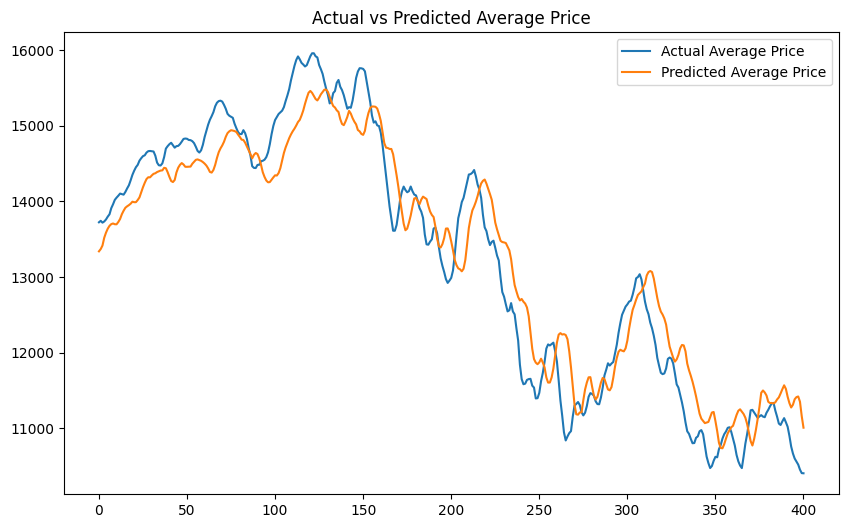

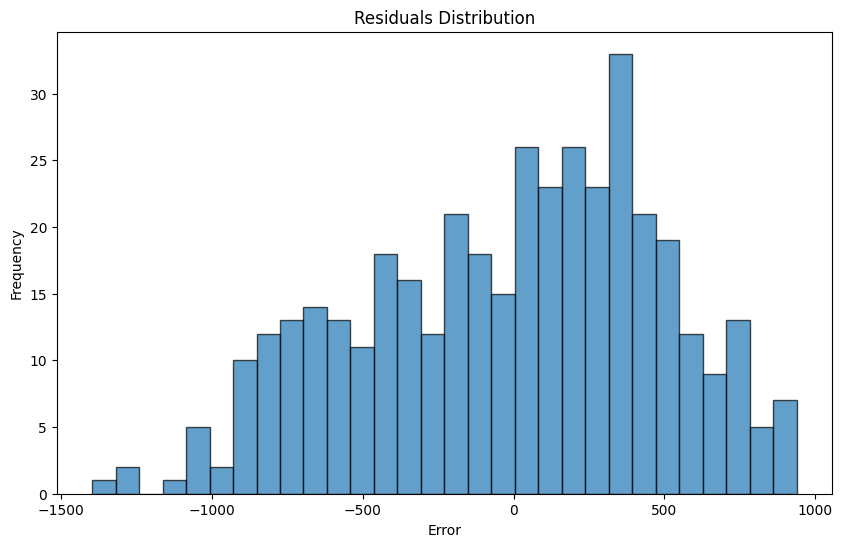

In [ ]:
# Step 2: Prepare Features (Using Open, High, Low, Close, Volume)
features_ohlcv = ['Open', 'High', 'Low', 'Close', 'Volume']
sequence_length = 5
X_ohlcv, y = create_sequences(nasdaq[features_ohlcv], nasdaq['Target'].values, sequence_length)
split_index = int(0.8 * len(X_ohlcv))
X_train, X_test = X_ohlcv[:split_index], X_ohlcv[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Scale the features and target
scaler_features = MinMaxScaler()
X_train_scaled = scaler_features.fit_transform(X_train.reshape(-1, X_train.shape[2]))
X_train = X_train_scaled.reshape(X_train.shape)

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1))
y_train = y_train_scaled

# Scale testing features and targets
X_test_scaled = scaler_features.transform(X_test.reshape(-1, X_test.shape[2]))
X_test = X_test_scaled.reshape(X_test.shape)

y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))
y_test = y_test_scaled

# Validation split: Use the last 10% of training data as validation
val_split_index = int(0.9 * len(X_train))
X_val, y_val = X_train[val_split_index:], y_train[val_split_index:]
X_train, y_train = X_train[:val_split_index], y_train[:val_split_index]

# Step 3: Model Design
model_historicalData = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')  # Linear activation for regression
])

model_historicalData.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Step 4: Model Training
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model_historicalData.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=0
)

# Step 5: Predictions
predictions_scaled = model_historicalData.predict(X_test)
predictions = scaler_target .inverse_transform(predictions_scaled)

y_test_rescaled = scaler_target .inverse_transform(y_test.reshape(-1, 1))

# Step 6: Evaluation
r2 = r2_score(y_test_rescaled, predictions)
print(f"R-squared: {r2:.4f}")

mape = mean_absolute_percentage_error(y_test_rescaled, predictions)
print(f"Mean Absolute Percentage Error: {mape:.4f}")

mse = mean_squared_error(y_test_rescaled, predictions)
print(f"Mean Squared Error: {mse:.4f}")

# Visualize predictions vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Average Price')
plt.plot(predictions, label='Predicted Average Price')
plt.legend()
plt.title("Actual vs Predicted Average Price")
plt.show()

errors = y_test_rescaled - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

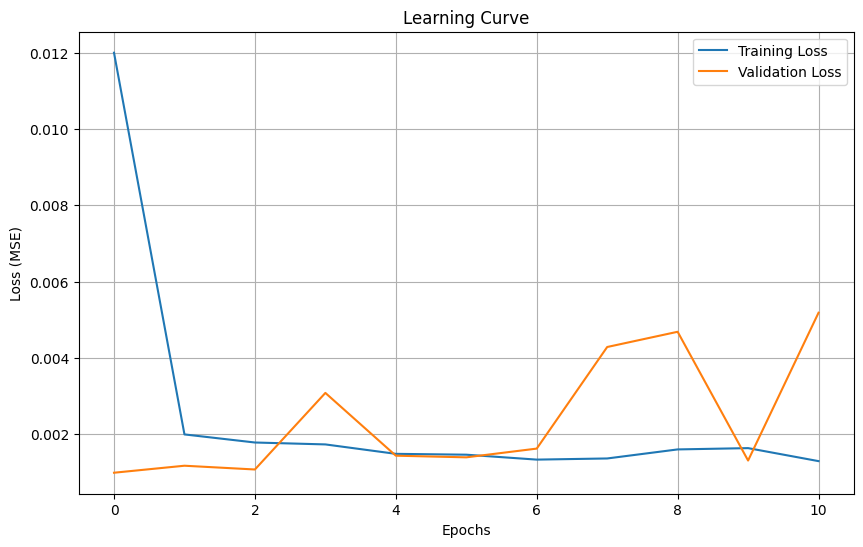

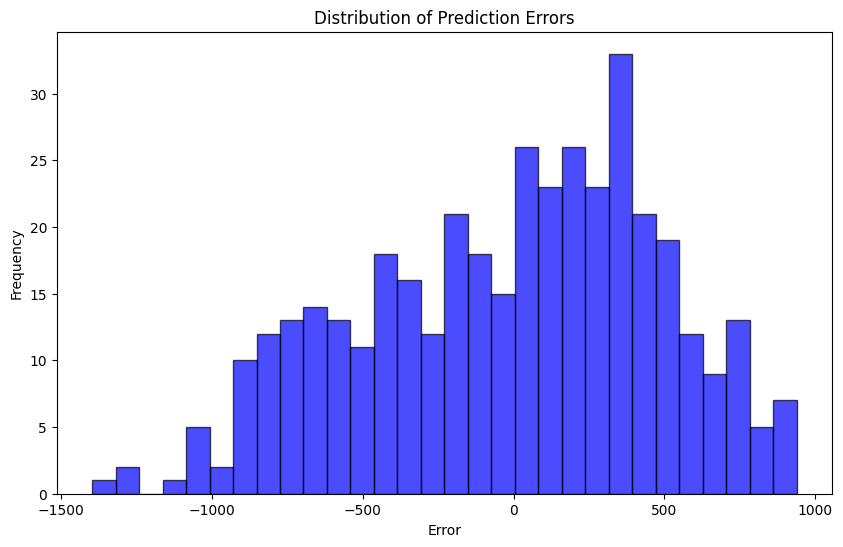

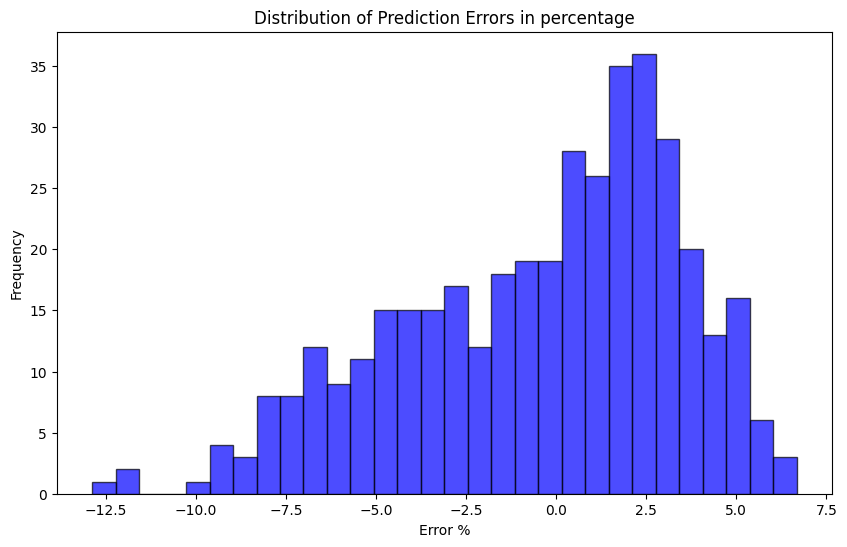

In [ ]:
# Visualization Example: Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Absolute error plotting
errors = y_test_rescaled - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# percentage error plotting
errors = 100*(y_test_rescaled - predictions)/y_test_rescaled
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Prediction Errors in percentage')
plt.xlabel('Error %')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pickle

# Save the trained model
model_historicalData.save("model_historicalData.h5")

# Save the scalers using pickle
with open("scaler_featuresHistory.pkl", "wb") as f:
    pickle.dump(scaler_features, f)

with open("scaler_targetHistory.pkl", "wb") as f:
    pickle.dump(scaler_target, f)

print("Model and scalers saved successfully!")

Model and scalers saved successfully!


# Using ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean Squared Error: 305667.4828
Mean Absolute Percentage Error: 0.0345
R-squared: 0.8925


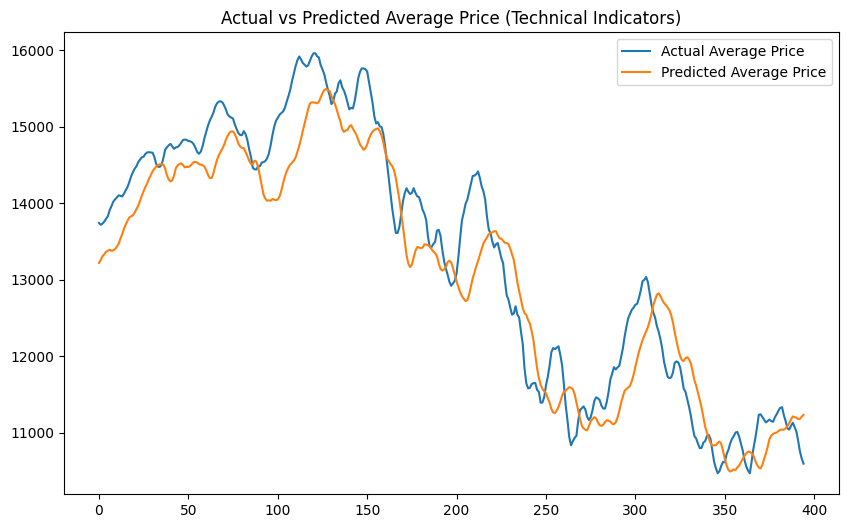

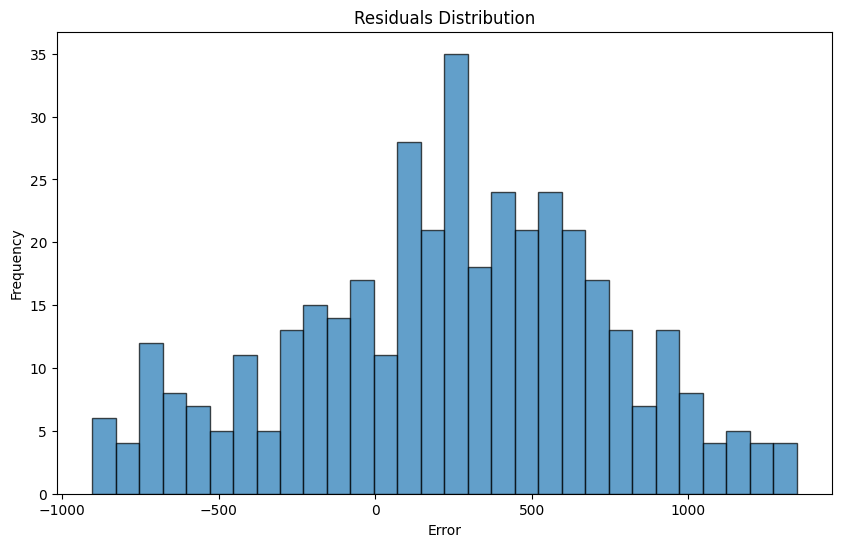

In [ ]:
# Step 2: Feature Engineering (Using Technical Indicators)
nasdaq['RSI'] = ta.momentum.RSIIndicator(nasdaq['Close'], window=14).rsi()
nasdaq['MACD'] = ta.trend.MACD(nasdaq['Close']).macd()
bollinger = ta.volatility.BollingerBands(nasdaq['Close'])
nasdaq['Bollinger_Upper'] = bollinger.bollinger_hband()
nasdaq['Bollinger_Lower'] = bollinger.bollinger_lband()
nasdaq['Volatility'] = nasdaq['Close'].rolling(window=20).std()

# Drop rows with NaN caused by rolling operations
nasdaq.dropna(inplace=True)

# Prepare Target: Predict the average price over the next 5 days
nasdaq['Target'] = nasdaq['Close'].rolling(window=5, min_periods=1).mean().shift(-5)
nasdaq.dropna(subset=['Target'], inplace=True)  # Drop rows with NaN in Target

# Features and scaling
features_technical = ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
scaler_features = MinMaxScaler()
scaled_features_technical = scaler_features.fit_transform(nasdaq[features_technical])



# Create sequences
sequence_length = 5
X_technical, y = create_sequences(scaled_features_technical, nasdaq['Target'].values, sequence_length)

# Chronological Train-Test Split
split_index = int(0.8 * len(X_technical))
X_train, X_test = X_technical[:split_index], X_technical[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Scale features and targets for train and test sets
scaler_features = MinMaxScaler()
X_train_scaled = scaler_features.fit_transform(X_train.reshape(-1, X_train.shape[2]))
X_train = X_train_scaled.reshape(X_train.shape)

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1))
y_train = y_train_scaled

X_test_scaled = scaler_features.transform(X_test.reshape(-1, X_test.shape[2]))
X_test = X_test_scaled.reshape(X_test.shape)

y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))
y_test = y_test_scaled

# Validation split: Use the last 10% of training data as validation
val_split_index = int(0.9 * len(X_train))
X_val, y_val = X_train[val_split_index:], y_train[val_split_index:]
X_train, y_train = X_train[:val_split_index], y_train[:val_split_index]

# Step 3: Model Design
model_technicalIdx = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')  # Linear activation for regression
])

model_technicalIdx.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Step 4: Model Training
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model_technicalIdx.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=0
)

# Step 5: Predictions
predictions_scaled = model_technicalIdx.predict(X_test)
predictions = scaler_target.inverse_transform(predictions_scaled)
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Evaluate predictions with additional metrics
mse = mean_squared_error(y_test_rescaled, predictions)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions)
r2 = r2_score(y_test_rescaled, predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")
print(f"R-squared: {r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Average Price')
plt.plot(predictions, label='Predicted Average Price')
plt.legend()
plt.title("Actual vs Predicted Average Price (Technical Indicators)")
plt.show()

# Visualize residuals
errors = y_test_rescaled - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

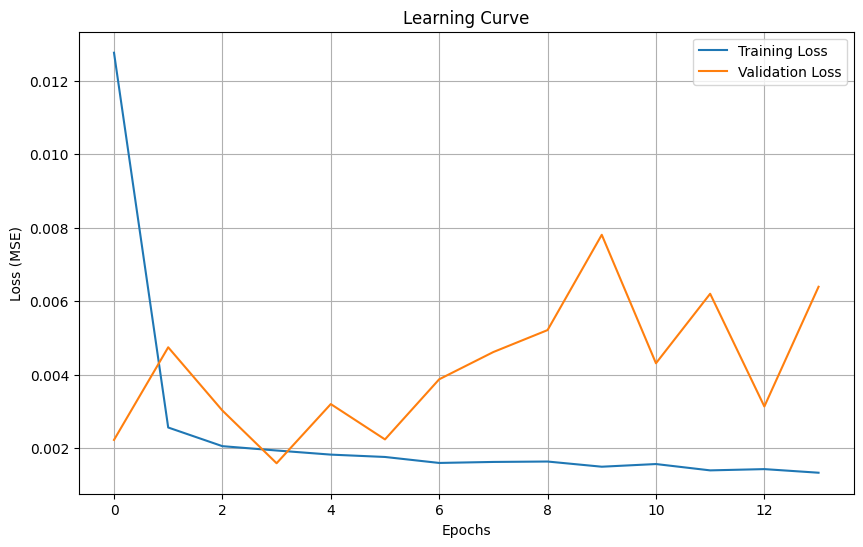

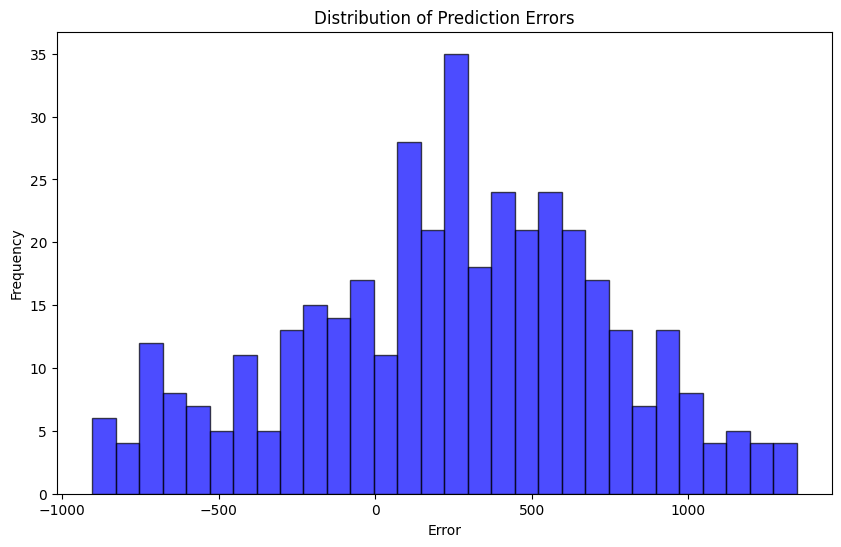

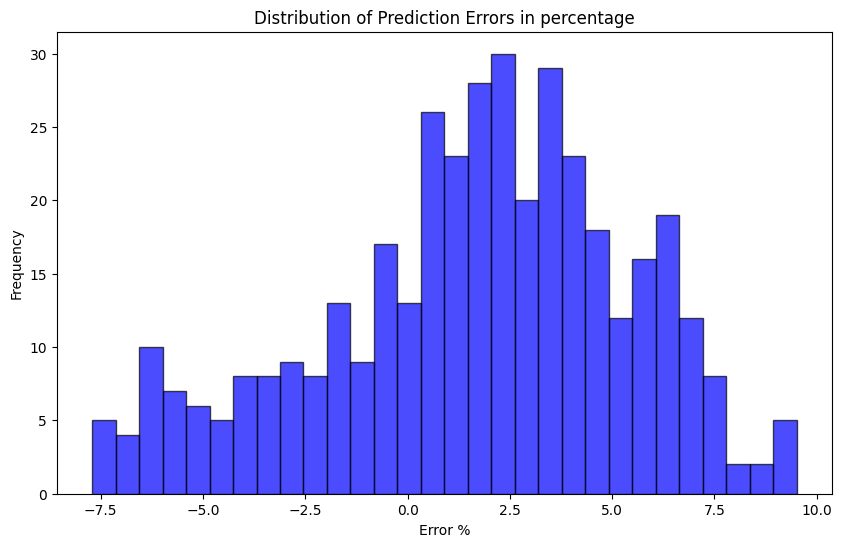

In [ ]:
# Visualization Example: Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Absolute error plotting
errors = y_test_rescaled - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# percentage error plotting
errors = 100*(y_test_rescaled - predictions)/y_test_rescaled
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Prediction Errors in percentage')
plt.xlabel('Error %')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pickle

# Save the trained model
model_technicalIdx.save("model_technicalIdx.h5")

# Save the scalers using pickle
with open("scaler_featuresIdx.pkl", "wb") as f:
    pickle.dump(scaler_features, f)

with open("scaler_targetIdx.pkl", "wb") as f:
    pickle.dump(scaler_target, f)

print("Model and scalers saved successfully!")


Model and scalers saved successfully!


Combining Sentiment index and historical data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model Test Mean Absolute Error: 0.0274
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean Squared Error: 193245.8534
Mean Absolute Error: 0.0279
R-squared: 0.9171


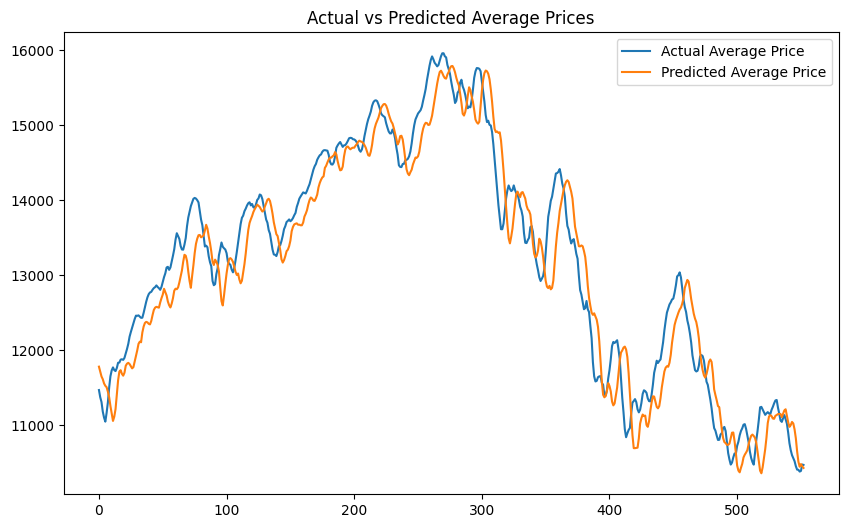

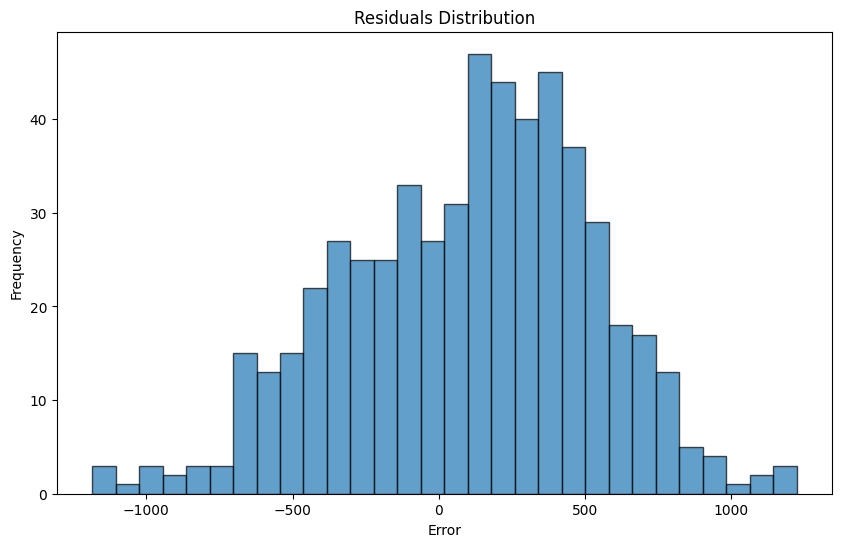

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 1: Data Collection
nasdaq = yf.download('^IXIC', start="2012-01-01", end="2023-01-01")
uvxy = yf.download('UVXY', start="2012-01-01", end="2023-01-01")
vix = yf.download('^VIX', start="2012-01-01", end="2023-01-01")

# Flatten MultiIndex columns if present
if isinstance(nasdaq.columns, pd.MultiIndex):
    nasdaq.columns = ['_'.join(col).strip() for col in nasdaq.columns.values]
if isinstance(uvxy.columns, pd.MultiIndex):
    uvxy.columns = ['_'.join(col).strip() for col in uvxy.columns.values]
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns.values]

# Keep relevant columns and rename
nasdaq = nasdaq[['Open_^IXIC', 'High_^IXIC', 'Low_^IXIC', 'Close_^IXIC', 'Volume_^IXIC']].rename(columns={
    'Open_^IXIC': 'Open',
    'High_^IXIC': 'High',
    'Low_^IXIC': 'Low',
    'Close_^IXIC': 'Close',
    'Volume_^IXIC': 'Volume'
})
uvxy = uvxy[['Adj Close_UVXY']].rename(columns={'Adj Close_UVXY': 'UVXY_Close'})
vix = vix[['Adj Close_^VIX']].rename(columns={'Adj Close_^VIX': 'VIX_Close'})

# Merge data on date
data = nasdaq.merge(uvxy, left_index=True, right_index=True, how='inner')
data = data.merge(vix, left_index=True, right_index=True, how='inner')

# Ensure no missing values
data['Close'] = pd.to_numeric(data['Close'], errors='coerce').ffill().bfill()
data['UVXY_Close'] = pd.to_numeric(data['UVXY_Close'], errors='coerce').ffill().bfill()
data['VIX_Close'] = pd.to_numeric(data['VIX_Close'], errors='coerce').ffill().bfill()

# Step 2: Feature Engineering
# Target: Predict the average price over the next 5 days
data['Target'] = data['Close'].shift(-5).rolling(window=5, min_periods=1).mean()

# Drop rows with NaN caused by shift
data.dropna(inplace=True)

# Features and scaling
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'UVXY_Close', 'VIX_Close']
scaler_X = MinMaxScaler()
scaled_features = scaler_X.fit_transform(data[features])

scaler_y = MinMaxScaler()
scaled_target = scaler_y.fit_transform(data['Target'].values.reshape(-1, 1))

# Step 3: Create Sequences
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 5
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

# Chronological Train-Test Split
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Validation split: Use the last 10% of training data as validation
val_split_index = int(0.9 * len(X_train))
X_val, y_val = X_train[val_split_index:], y_train[val_split_index:]
X_train, y_train = X_train[:val_split_index], y_train[:val_split_index]

# Step 4: Model Design
model_combined = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='linear')  # Linear activation for regression
])

model_combined.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Step 5: Model Training
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model_combined.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=0
)

# Step 6: Evaluation
loss, mae = model_combined.evaluate(X_test, y_test, verbose=0)
print(f"Model Test Mean Absolute Error: {mae:.4f}")

# Step 7: Predictions
scaled_predictions = model_combined.predict(X_test)
predictions = scaler_y.inverse_transform(scaled_predictions)  # Inverse transform predictions
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual target

# Evaluate predictions with additional metrics
mse = mean_squared_error(y_test_original, predictions)
mape = mean_absolute_percentage_error(y_test_original, predictions)
r2 = r2_score(y_test_original, predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mape:.4f}")
print(f"R-squared: {r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Average Price')
plt.plot(predictions, label='Predicted Average Price')
plt.legend()
plt.title("Actual vs Predicted Average Prices")
plt.show()

# Visualize residuals
errors = y_test_original - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

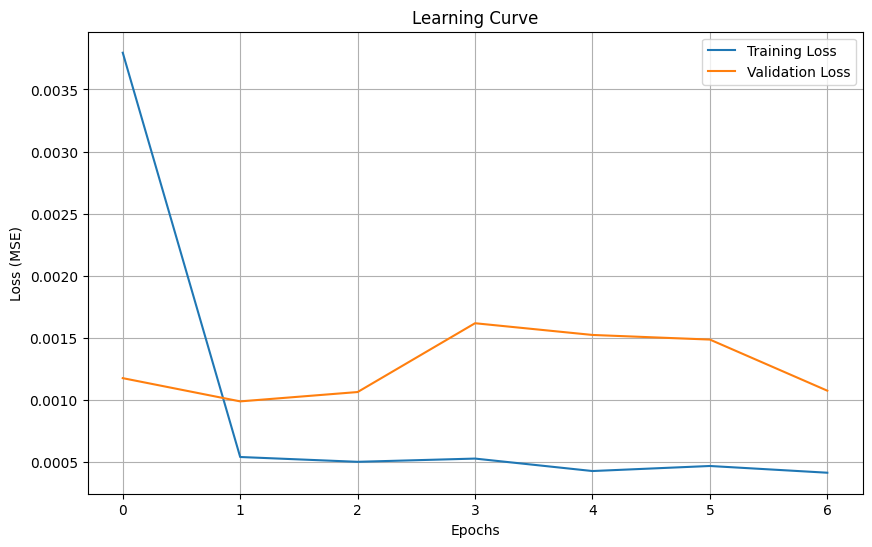

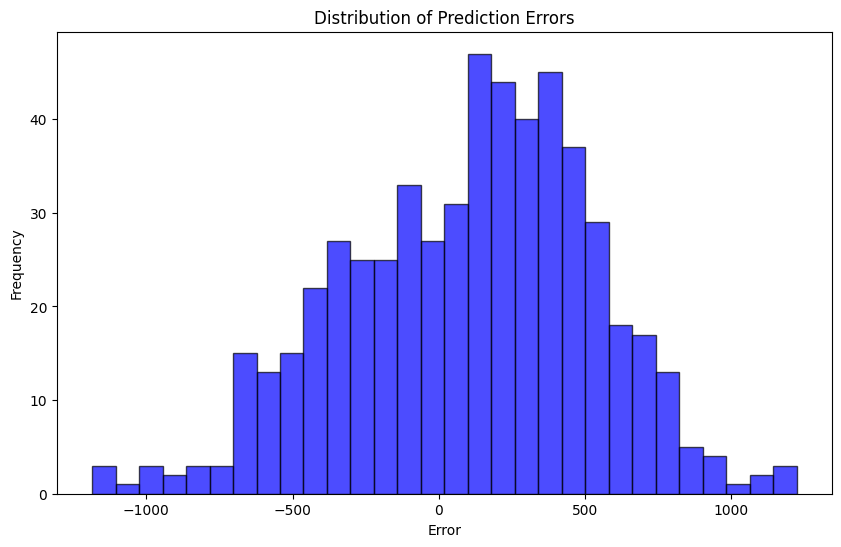

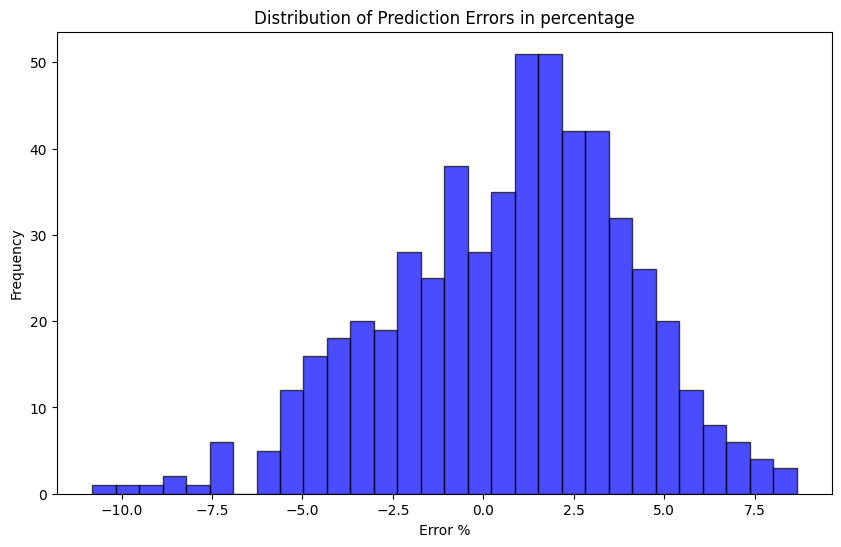

In [ ]:
# Visualization Example: Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Absolute error plotting
errors = y_test_original - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# percentage error plotting
errors = 100*(y_test_original - predictions)/y_test_original
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Prediction Errors in percentage')
plt.xlabel('Error %')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pickle

# Save the trained model
model_combined.save("model_combined.h5")

# Save the scalers using pickle
with open("scaler_featuresCombined.pkl", "wb") as f:
    pickle.dump(scaler_X, f)

with open("scaler_targetCombined.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

print("Model and scalers saved successfully!")


Model and scalers saved successfully!


Mixture of Experts

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import ta
import matplotlib.pyplot as plt

# Step 1: Data Collection
nasdaq = yf.download('^IXIC', start="2012-01-01", end="2023-01-01")
uvxy = yf.download('UVXY', start="2012-01-01", end="2023-01-01")
vix = yf.download('^VIX', start="2012-01-01", end="2023-01-01")

# Flatten MultiIndex columns if necessary
if isinstance(nasdaq.columns, pd.MultiIndex):
    nasdaq.columns = ['_'.join(col).strip() for col in nasdaq.columns.values]
if isinstance(uvxy.columns, pd.MultiIndex):
    uvxy.columns = ['_'.join(col).strip() for col in uvxy.columns.values]
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns.values]

# Select and rename relevant columns
uvxy_close_col = 'Close_UVXY' if 'Close_UVXY' in uvxy.columns else 'Adj Close_UVXY'
vix_close_col = 'Close_^VIX' if 'Close_^VIX' in vix.columns else 'Adj Close_^VIX'

uvxy = uvxy[[uvxy_close_col]].rename(columns={uvxy_close_col: 'UVXY_Close'})
vix = vix[[vix_close_col]].rename(columns={vix_close_col: 'VIX_Close'})

# Merge UVXY and VIX data with NASDAQ data
nasdaq = nasdaq.merge(uvxy, left_index=True, right_index=True, how='inner')
nasdaq = nasdaq.merge(vix, left_index=True, right_index=True, how='inner')

# Rename NASDAQ columns for easier reference
nasdaq.rename(columns={
    'Open_^IXIC': 'Open',
    'High_^IXIC': 'High',
    'Low_^IXIC': 'Low',
    'Close_^IXIC': 'Close',
    'Volume_^IXIC': 'Volume'
}, inplace=True)

# Ensure no missing values after merging
nasdaq['UVXY_Close'] = pd.to_numeric(nasdaq['UVXY_Close'], errors='coerce').ffill().bfill()
nasdaq['VIX_Close'] = pd.to_numeric(nasdaq['VIX_Close'], errors='coerce').ffill().bfill()

# Step 2: Feature Preparation and Scaling
# Features for Model 1 (OHLCV + UVXY + VIX)
features_ohlcv_uvxy_vix = ['Open', 'High', 'Low', 'Close', 'Volume', 'UVXY_Close', 'VIX_Close']
scaler_featureModel1 = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_features_ohlcv = scaler_featureModel1.fit_transform(nasdaq[features_ohlcv_uvxy_vix])

# Features for Model 2 (Technical Indicators)
nasdaq['RSI'] = ta.momentum.RSIIndicator(nasdaq['Close'], window=14).rsi()
nasdaq['MACD'] = ta.trend.MACD(nasdaq['Close']).macd()
bollinger = ta.volatility.BollingerBands(nasdaq['Close'])
nasdaq['Bollinger_Upper'] = bollinger.bollinger_hband()
nasdaq['Bollinger_Lower'] = bollinger.bollinger_lband()
nasdaq['Volatility'] = nasdaq['Close'].rolling(window=20).std()

features_tech = ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
nasdaq.dropna(inplace=True)
scaler_featureModel2 = MinMaxScaler()
scaled_features_tech = scaler_featureModel2.fit_transform(nasdaq[features_tech])
# Features for gates
shared_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'UVXY_Close', 'VIX_Close',
                   'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
scaler_featureGate = MinMaxScaler()
scaled_features_gate = scaler_featureGate.fit_transform(nasdaq[shared_features])

# Target variable: Average price over the next 5 days
nasdaq['Target'] = nasdaq['Close'].shift(-5).rolling(window=5, min_periods=1).mean()
nasdaq.dropna(subset=['Target'], inplace=True)
nasdaq['Target'] = scaler_y.fit_transform(nasdaq[['Target']])

# Step 3: Create Sequences
sequence_length = 5

def create_sequences(features, target, sequence_length):
    valid_length = min(len(features), len(target)) - sequence_length
    features = features[:valid_length + sequence_length]
    target = target[:valid_length]

    X, y = [], []
    for i in range(valid_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i])
    return np.array(X), np.array(y)

# Sequences for Model 1 and Model 2
X_ohlcv, y = create_sequences(scaled_features_ohlcv, nasdaq['Target'].values, sequence_length)
X_tech, _ = create_sequences(scaled_features_tech, nasdaq['Target'].values, sequence_length)
X_gate, _ = create_sequences(scaled_features_gate, nasdaq['Target'].values, sequence_length)

# Train-test split
# Chronological Train-Test Split
split_index = int(0.8 * len(X_ohlcv))
X_train1, X_test1 = X_ohlcv[:split_index], X_ohlcv[split_index:]
X_train2, X_test2 = X_tech[:split_index], X_tech[split_index:]
X_GateTrain, X_GateTest = X_gate[:split_index], X_gate[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Validation split: Use the last 10% of training data as validation
val_split_index = int(0.9 * len(X_train1))
X_val1, y_val = X_train1[val_split_index:], y_train[val_split_index:]
X_train1, y_train = X_train1[:val_split_index], y_train[:val_split_index]

X_val2 = X_train2[val_split_index:]
X_train2 = X_train2[:val_split_index]


# Step 4: Define LSTM Models
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(100, return_sequences=False),
        Dropout(0.3),
        Dense(1, activation='linear')  # Linear activation for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Define Model 1 and Model 2
model1 = create_lstm_model((X_train1.shape[1], X_train1.shape[2]))
model2 = create_lstm_model((X_train2.shape[1], X_train2.shape[2]))

# Define Gating Network
gating_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_GateTrain.shape[1], X_GateTrain.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(2, activation='softmax')  # Two outputs: weights for Model 1 and Model 2
])
gating_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train Models
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_model1 = model1.fit(X_train1, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
history_model2 = model2.fit(X_train2, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)

pred1_train = model1.predict(X_train1)
pred2_train = model2.predict(X_train2)

y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1))
pred1_train_original = scaler_y.inverse_transform(pred1_train)
pred2_train_original = scaler_y.inverse_transform(pred2_train)

error1 = np.abs(pred1_train_original - y_train_original)
error2 = np.abs(pred2_train_original - y_train_original)

# Convert errors to weights (inverse of error, normalized)
weights1 = 1 / (error1 + 1e-6)  # Adding a small constant to avoid division by zero
weights2 = 1 / (error2 + 1e-6)
sum_weights = weights1 + weights2
weights1_normalized = weights1 / sum_weights
weights2_normalized = weights2 / sum_weights

y_gating_train = np.hstack([weights1_normalized, weights2_normalized])
X_GateTrain = X_GateTrain[:val_split_index]

# Train Gating Network
history_gateModel = gating_model.fit(
    X_GateTrain, y_gating_train, epochs=50, batch_size=32, validation_split=0.1,
    callbacks=[early_stopping], verbose=0
)

# Step 6: Evaluation and Metrics
# Generate predictions from both experts on the test set
pred1_test = model1.predict(X_test1)
pred2_test = model2.predict(X_test2)

# Predict weights from the gating network
gating_weights_test = gating_model.predict(X_GateTest)

# Combine predictions using the gating network weights
final_predictions = gating_weights_test[:, 0:1] * pred1_test + gating_weights_test[:, 1:2] * pred2_test

# Inverse transform predictions and target values
predictions_original = scaler_y.inverse_transform(final_predictions)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Evaluate metrics
mse = mean_squared_error(y_test_original, predictions_original)
rmse = np.sqrt(mse)
maqe = mean_absolute_percentage_error(y_test_original, predictions_original)
r2 = r2_score(y_test_original, predictions_original)
mae = mean_absolute_error(y_test_original, predictions_original)
mape = np.mean(np.abs((y_test_original - predictions_original) / y_test_original)) * 100

real_direction = np.sign(np.diff(y_test_original.ravel()))  # +1 for up, -1 for down, 0 for no change
predicted_direction = np.sign(np.diff(predictions_original.ravel()))  # Same for predictions

# Compare the directions
correct_directions = real_direction == predicted_direction

# Calculate Directional Percentage of Error (DPE)
dpa = np.sum(correct_directions) / len(correct_directions) * 100

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Directional Percentage of Accuracy (DPA): {dpa:.2f}%")


# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Average Price')
plt.plot(predictions_original, label='Predicted Average Price (MOE)', color='green')
plt.legend()
plt.title("Actual vs Predicted Prices (MOE)")
plt.show()

# Visualize residuals
errors = y_test_original - predictions_original
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.title("Residuals Distribution (MOE)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


NameError: name 'mean_absolute_percentage_error' is not defined

In [ ]:
print(model1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 100)              │          43,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 371,105 (1.42 MB)

 Trainable params: 123,701 (483.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 247,404 (966.43 KB)

None


In [ ]:
real_direction = np.sign(np.diff(y_test_original.ravel()))  # +1 for up, -1 for down, 0 for no change
predicted_direction = np.sign(np.diff(predictions_original.ravel()))  # Same for predictions

# Compare the directions
correct_directions = real_direction == predicted_direction

# Calculate Directional Percentage of Error (DPE)
dpa = np.sum(correct_directions) / len(correct_directions) * 100
print(f"Directional Percentage of Accuracy (DPA): {dpa:.2f}%")


Directional Percentage of Accuracy (DPA): 73.31%


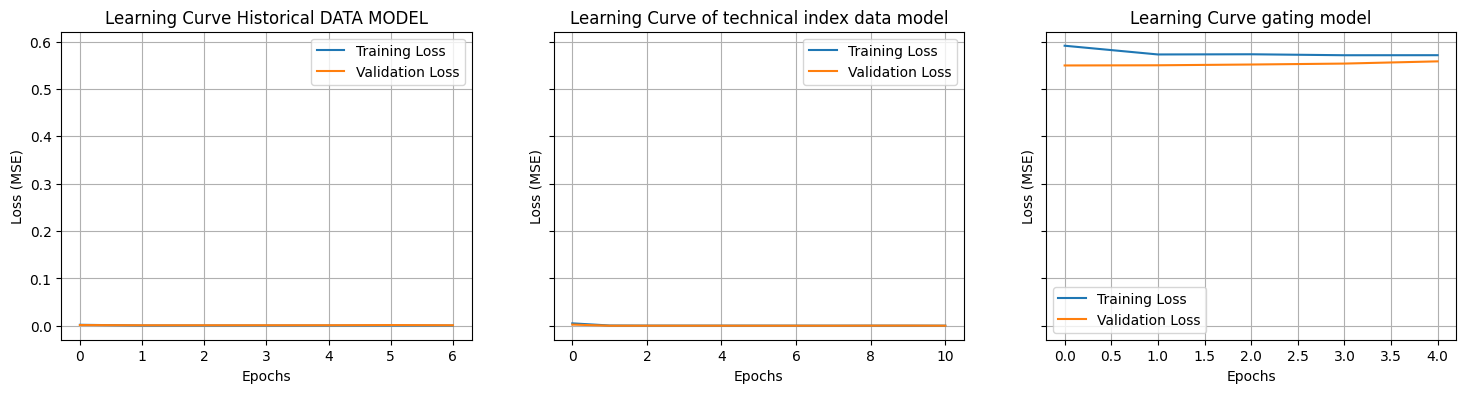

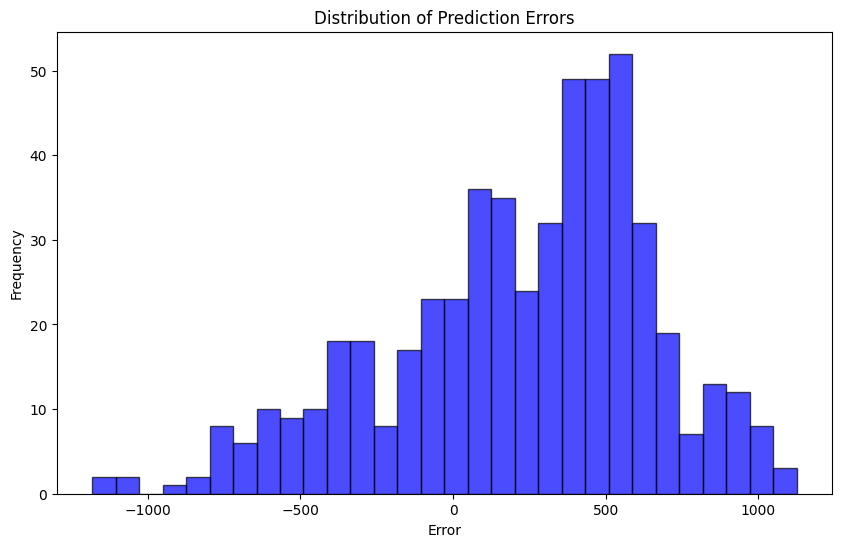

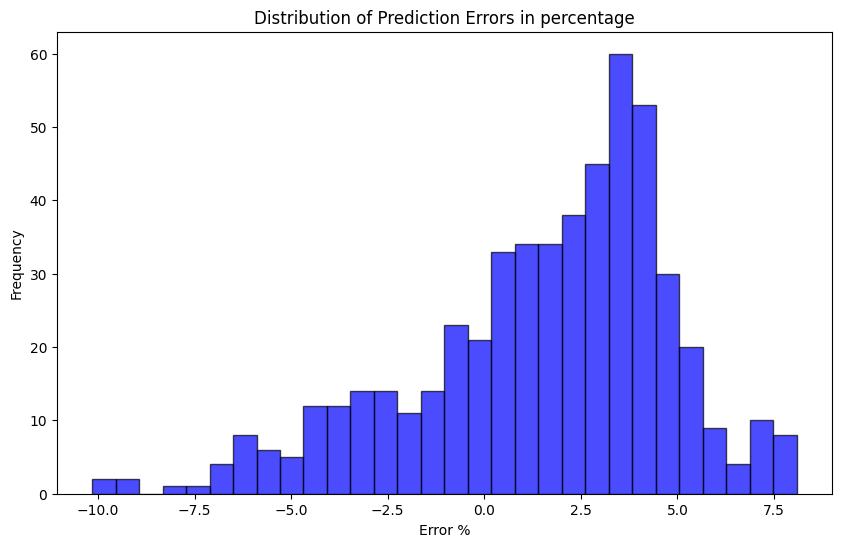

In [ ]:
# Visualization Example: Learning Curve
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18, 4))
ax1.plot(history_model1.history['loss'], label='Training Loss')
ax1.plot(history_model1.history['val_loss'], label='Validation Loss')
ax1.set_title('Learning Curve Historical DATA MODEL')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True)

ax2.plot(history_model2.history['loss'], label='Training Loss')
ax2.plot(history_model2.history['val_loss'], label='Validation Loss')
ax2.set_title('Learning Curve of technical index data model')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss (MSE)')
ax2.legend()
ax2.grid(True)

ax3.plot(history_gateModel.history['loss'], label='Training Loss')
ax3.plot(history_gateModel.history['val_loss'], label='Validation Loss')
ax3.set_title('Learning Curve gating model')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss (MSE)')
ax3.legend()
ax3.grid(True)
plt.show()

# Absolute error plotting
errors = y_test_original - predictions_original
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# percentage error plotting
errors = 100*(y_test_original - predictions_original)/y_test_original
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Prediction Errors in percentage')
plt.xlabel('Error %')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pickle

# Save the trained model
model1.save("model1.h5")
model2.save("model2.h5")
gating_model.save("gating_model.h5")

# Save the scalers using pickle
with open("scaler_featureModel1.pkl", "wb") as f:
    pickle.dump(scaler_featureModel1, f)
with open("scaler_featureModel2.pkl", "wb") as f:
    pickle.dump(scaler_featureModel2, f)
with open("scaler_featureMOE.pkl", "wb") as f:
    pickle.dump(scaler_featureGate, f)

with open("scaler_targetMOE.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

print("Model and scalers saved successfully!")


Model and scalers saved successfully!


Predict the stock market price of another period: 2023-01-01 to 2024-10-30

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("model_historicalData.h5")

# Load the scalers
with open("scaler_featuresHistory.pkl", "rb") as f:
    loaded_scaler_features = pickle.load(f)

with open("scaler_targetHistory.pkl", "rb") as f:
    loaded_scaler_target = pickle.load(f)

print("Model and scalers loaded successfully!")

Model and scalers loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
<ipython-input-13-6b99ab88da0d>:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(target[i])


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


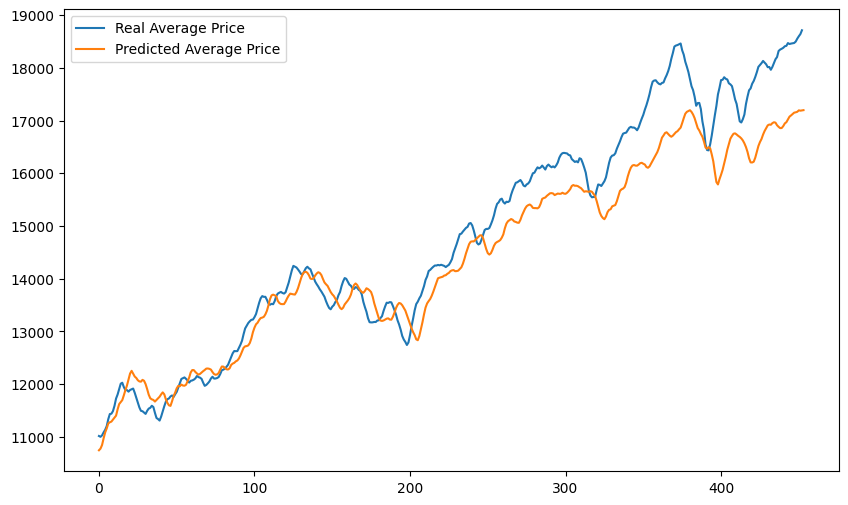

R² Score: 0.9048
Mean Absolute Error (MAE): 513.4246
Mean Squared Error (MSE): 448659.0037
Root Mean Squared Error (RMSE): 669.8201
Mean Absolute Percentage Error (MAPE): 15.60%


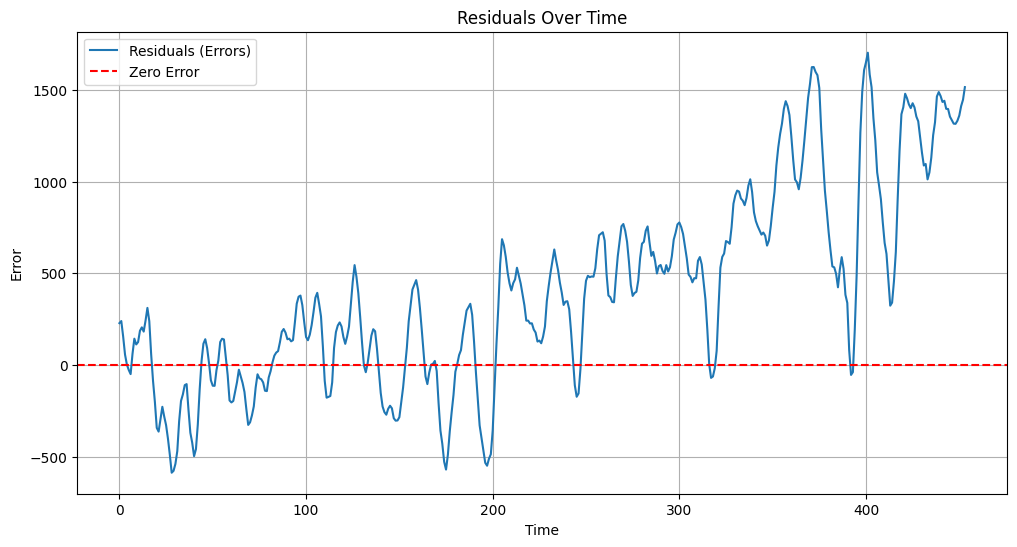

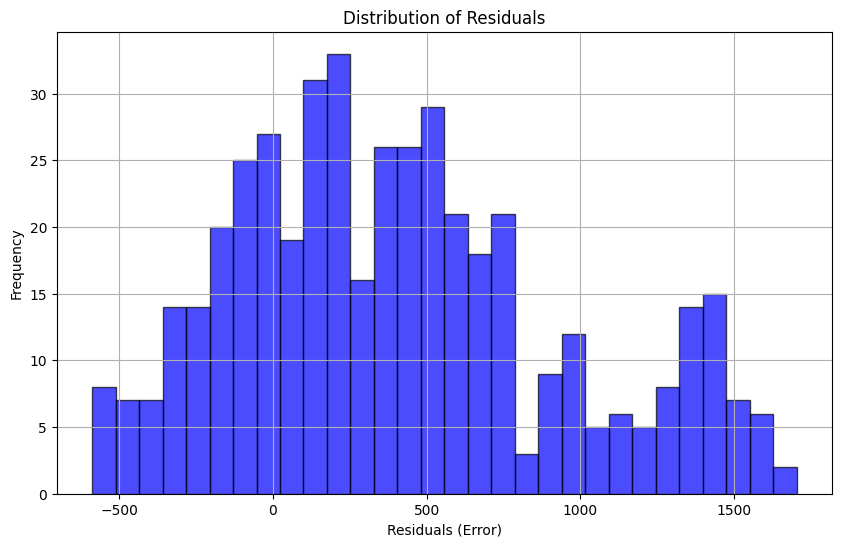

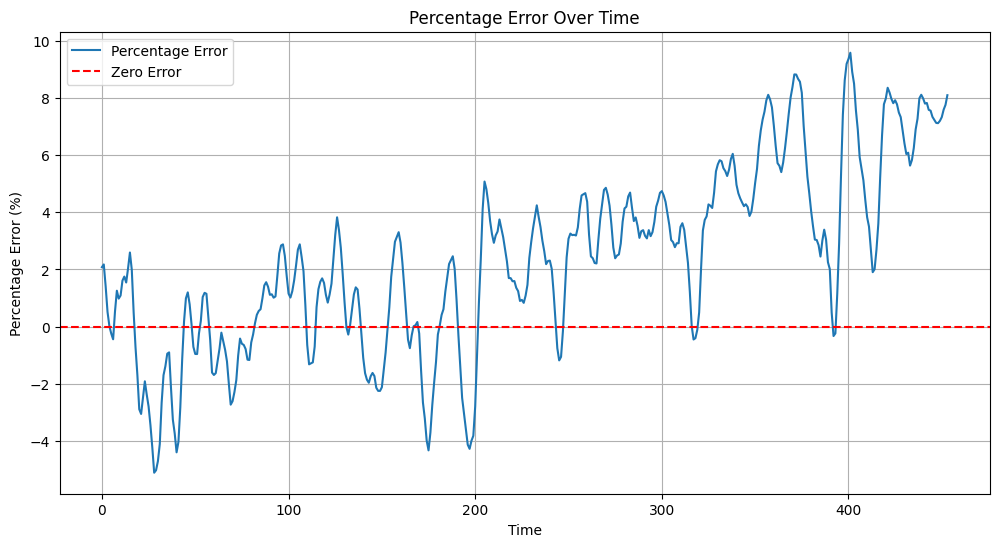

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import ta  # Technical Analysis library
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Data Collection
nasdaq = yf.download('^IXIC', start="2023-01-01", end="2024-10-30")
uvxy = yf.download('UVXY', start="2023-01-01", end="2024-10-30")
vix = yf.download('^VIX', start="2023-01-01", end="2024-10-30")

# Flatten MultiIndex columns if necessary
if isinstance(nasdaq.columns, pd.MultiIndex):
    nasdaq.columns = ['_'.join(col).strip() for col in nasdaq.columns.values]
if isinstance(uvxy.columns, pd.MultiIndex):
    uvxy.columns = ['_'.join(col).strip() for col in uvxy.columns.values]
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns.values]

# Select and rename relevant columns
uvxy_close_col = 'Close_UVXY' if 'Close_UVXY' in uvxy.columns else 'Adj Close_UVXY'
vix_close_col = 'Close_^VIX' if 'Close_^VIX' in vix.columns else 'Adj Close_^VIX'

uvxy = uvxy[[uvxy_close_col]].rename(columns={uvxy_close_col: 'UVXY_Close'})
vix = vix[[vix_close_col]].rename(columns={vix_close_col: 'VIX_Close'})

# Merge UVXY and VIX data with NASDAQ data
nasdaq = nasdaq.merge(uvxy, left_index=True, right_index=True, how='inner')
nasdaq = nasdaq.merge(vix, left_index=True, right_index=True, how='inner')

# Rename NASDAQ columns for easier reference
nasdaq.rename(columns={
    'Open_^IXIC': 'Open',
    'High_^IXIC': 'High',
    'Low_^IXIC': 'Low',
    'Close_^IXIC': 'Close',
    'Volume_^IXIC': 'Volume'
}, inplace=True)

nasdaq['Target'] = nasdaq['Close'].shift(-5).rolling(window=5, min_periods=1).mean()

# Different model and prediction
# Historical model input ['Open', 'High', 'Low', 'Close', 'Volume']
features_historical = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled_features_historical = loaded_scaler_features.transform(nasdaq[features_historical])
sequence_length = 5
x_feature, _ = create_sequences(scaled_features_historical, nasdaq['Target'], sequence_length)

# Prediction
predictions_scaled = loaded_model.predict(x_feature)
predictions_historical = loaded_scaler_target.inverse_transform(predictions_scaled)

# Compare with actual values
nasdaq['Target'] = nasdaq['Close'].shift(-5).rolling(window=5, min_periods=1).mean()
nasdaq.dropna(subset=['Target'], inplace=True)
real_price = nasdaq['Target'].values

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(real_price[sequence_length:], label='Real Average Price')
plt.plot(predictions_historical, label='Predicted Average Price')
plt.legend()
plt.show()

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Performance Metrics
r2 = r2_score(real_price[sequence_length-1:], predictions_historical)
mae = mean_absolute_error(real_price[sequence_length-1:], predictions_historical)
mse = mean_squared_error(real_price[sequence_length-1:], predictions_historical)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((real_price[sequence_length-1:] - predictions_historical) / real_price[sequence_length-1:])) * 100

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot Residuals Over Time
residuals = real_price[sequence_length-1:] - predictions_historical.squeeze()
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals (Errors)")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# Error Distribution (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Percentage Error Over Time
percentage_errors = (residuals / real_price[sequence_length-1:]) * 100
plt.figure(figsize=(12, 6))
plt.plot(percentage_errors, label="Percentage Error")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Percentage Error Over Time")
plt.xlabel("Time")
plt.ylabel("Percentage Error (%)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("model_technicalIdx.h5")

# Load the scalers
with open("scaler_featuresIdx.pkl", "rb") as f:
    loaded_scaler_features = pickle.load(f)

with open("scaler_targetIdx.pkl", "rb") as f:
    loaded_scaler_target = pickle.load(f)

print("Model and scalers loaded successfully!")

Model and scalers loaded successfully!


Model and scalers loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
<ipython-input-13-6b99ab88da0d>:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(target[i])


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


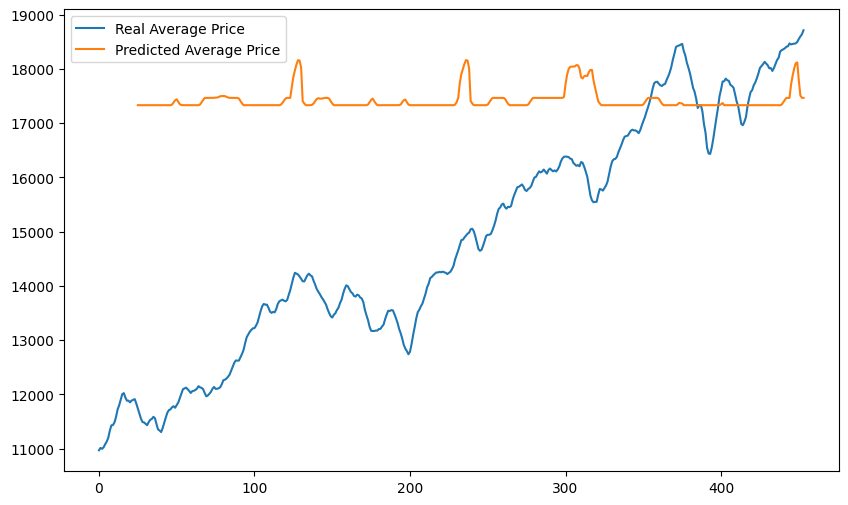

R² Score: -1.3492
Mean Absolute Error (MAE): 2648.1597
Mean Squared Error (MSE): 10178304.4997
Root Mean Squared Error (RMSE): 3190.3455
Mean Absolute Percentage Error (MAPE): 19.69%


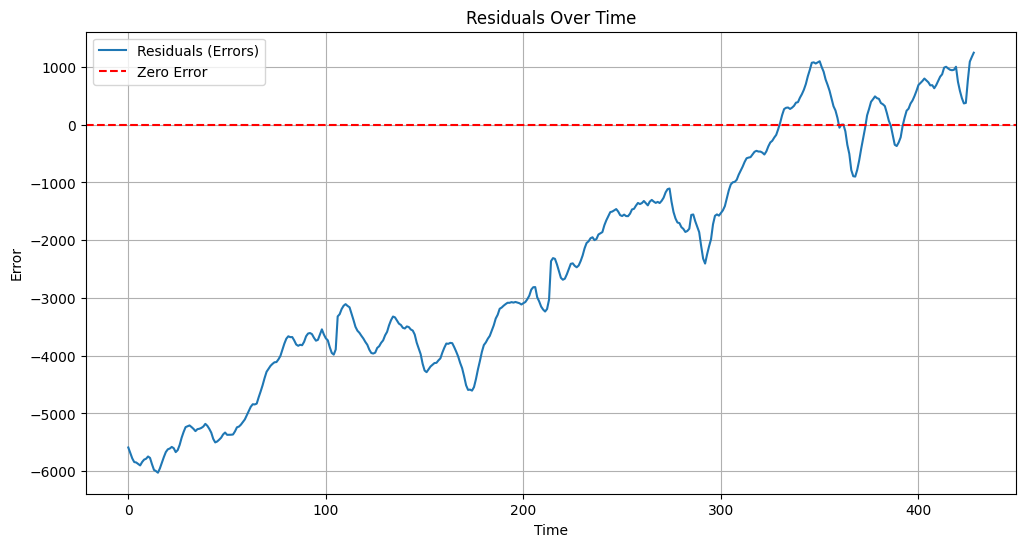

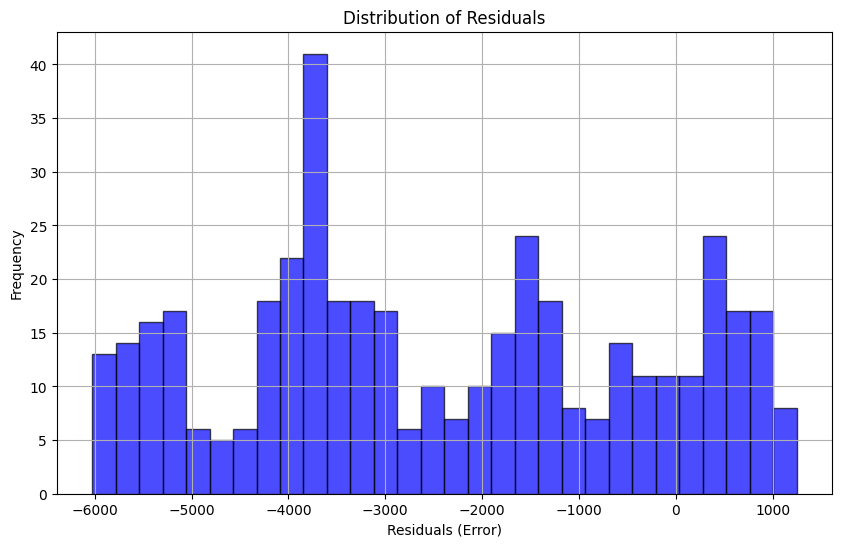

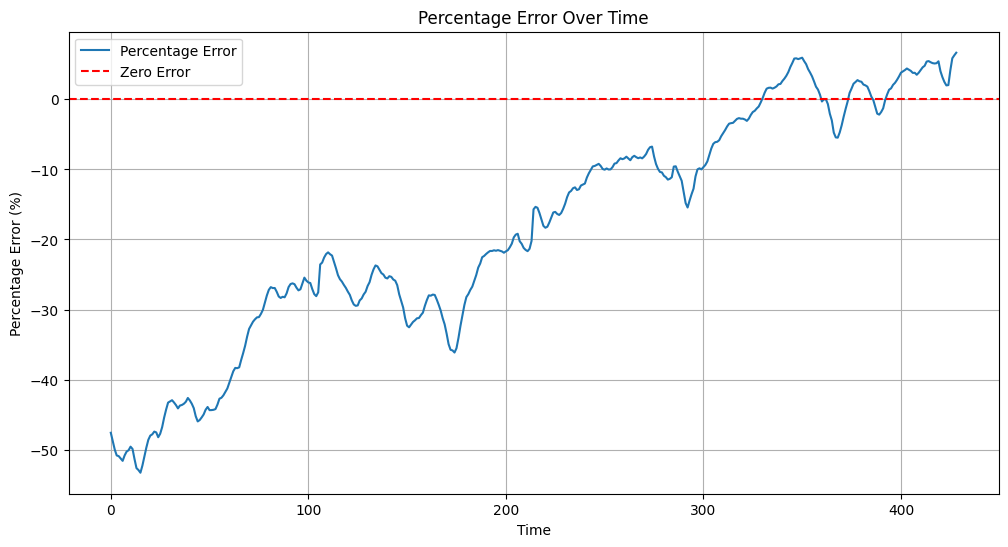

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("model_technicalIdx.h5")

# Load the scalers
with open("scaler_featuresIdx.pkl", "rb") as f:
    loaded_scaler_features = pickle.load(f)

with open("scaler_targetIdx.pkl", "rb") as f:
    loaded_scaler_target = pickle.load(f)

print("Model and scalers loaded successfully!")
# Step 1: Data Collection
nasdaq = yf.download('^IXIC', start="2023-01-01", end="2024-10-30")
uvxy = yf.download('UVXY', start="2023-01-01", end="2024-10-30")
vix = yf.download('^VIX', start="2023-01-01", end="2024-10-30")

# Flatten MultiIndex columns if necessary
if isinstance(nasdaq.columns, pd.MultiIndex):
    nasdaq.columns = ['_'.join(col).strip() for col in nasdaq.columns.values]
if isinstance(uvxy.columns, pd.MultiIndex):
    uvxy.columns = ['_'.join(col).strip() for col in uvxy.columns.values]
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns.values]

# Select and rename relevant columns
uvxy_close_col = 'Close_UVXY' if 'Close_UVXY' in uvxy.columns else 'Adj Close_UVXY'
vix_close_col = 'Close_^VIX' if 'Close_^VIX' in vix.columns else 'Adj Close_^VIX'

uvxy = uvxy[[uvxy_close_col]].rename(columns={uvxy_close_col: 'UVXY_Close'})
vix = vix[[vix_close_col]].rename(columns={vix_close_col: 'VIX_Close'})

# Merge UVXY and VIX data with NASDAQ data
nasdaq = nasdaq.merge(uvxy, left_index=True, right_index=True, how='inner')
nasdaq = nasdaq.merge(vix, left_index=True, right_index=True, how='inner')

# Rename NASDAQ columns for easier reference
nasdaq.rename(columns={
    'Open_^IXIC': 'Open',
    'High_^IXIC': 'High',
    'Low_^IXIC': 'Low',
    'Close_^IXIC': 'Close',
    'Volume_^IXIC': 'Volume'
}, inplace=True)

nasdaq['Target'] = nasdaq['Close'].shift(-5).rolling(window=5, min_periods=1).mean()

nasdaq['RSI'] = ta.momentum.RSIIndicator(nasdaq['Close'], window=14).rsi()
nasdaq['MACD'] = ta.trend.MACD(nasdaq['Close']).macd()
bollinger = ta.volatility.BollingerBands(nasdaq['Close'])
nasdaq['Bollinger_Upper'] = bollinger.bollinger_hband()
nasdaq['Bollinger_Lower'] = bollinger.bollinger_lband()
nasdaq['Volatility'] = nasdaq['Close'].rolling(window=20).std()
# Technical model input ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
features_tech = ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
scaled_features_technical = loaded_scaler_features.transform(nasdaq[features_tech])
sequence_length = 5
x_feature, _ = create_sequences(scaled_features_technical, nasdaq['Target'], sequence_length)

# Prediction
predictions_scaled = loaded_model.predict(x_feature)
predictions_technical = loaded_scaler_target.inverse_transform(predictions_scaled)

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(real_price[sequence_length-1:len(predictions_technical)+ sequence_length], label='Real Average Price')
plt.plot(predictions_technical, label='Predicted Average Price')
plt.legend()
plt.show()

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ensure no NaN values in real_price and predictions_technical
real_price_aligned = real_price[sequence_length - 1: len(predictions_technical) + sequence_length - 1].squeeze()
predictions_technical_squeezed = predictions_technical.squeeze()
valid_indices = ~np.isnan(real_price_aligned) & ~np.isnan(predictions_technical_squeezed)
valid_indices = valid_indices.ravel()

# Filter out NaN values
filtered_real_price = real_price_aligned[valid_indices]
filtered_predictions_technical = predictions_technical_squeezed[valid_indices]

# Performance Metrics
r2 = r2_score(filtered_real_price, filtered_predictions_technical)
mae = mean_absolute_error(filtered_real_price, filtered_predictions_technical)
mse = mean_squared_error(filtered_real_price, filtered_predictions_technical)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((filtered_real_price - filtered_predictions_technical)
          / filtered_real_price)) * 100

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot Residuals Over Time
residuals = filtered_real_price - filtered_predictions_technical.squeeze()
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals (Errors)")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# Error Distribution (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Percentage Error Over Time
percentage_errors = (residuals / filtered_real_price) * 100
plt.figure(figsize=(12, 6))
plt.plot(percentage_errors, label="Percentage Error")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Percentage Error Over Time")
plt.xlabel("Time")
plt.ylabel("Percentage Error (%)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model("model_combined.h5")

# Load the scalers
with open("scaler_featuresCombined.pkl", "rb") as f:
    loaded_scaler_features = pickle.load(f)

with open("scaler_targetCombined.pkl", "rb") as f:
    loaded_scaler_target = pickle.load(f)

print("Model and scalers loaded successfully!")

Model and scalers loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-13-6b99ab88da0d>:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(target[i])


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


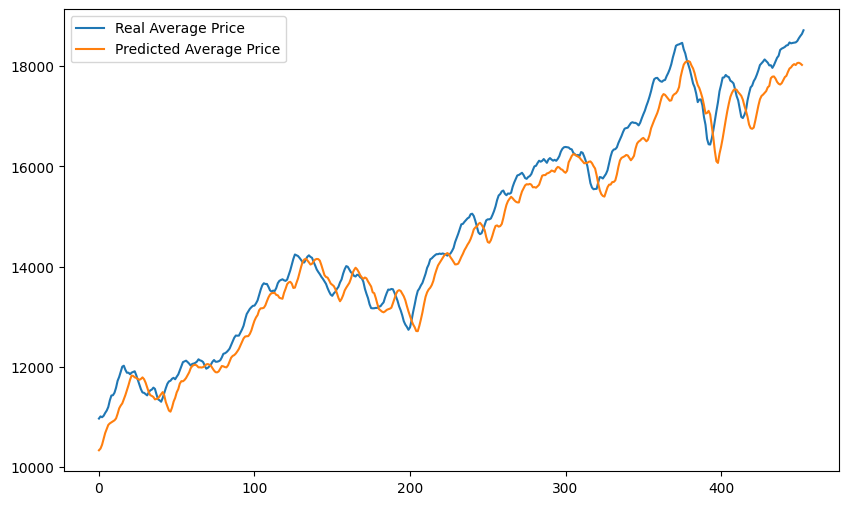

R² Score: 0.9546
Mean Absolute Error (MAE): 387.6635
Mean Squared Error (MSE): 212931.7542
Root Mean Squared Error (RMSE): 461.4453
Mean Absolute Percentage Error (MAPE): 2.58%


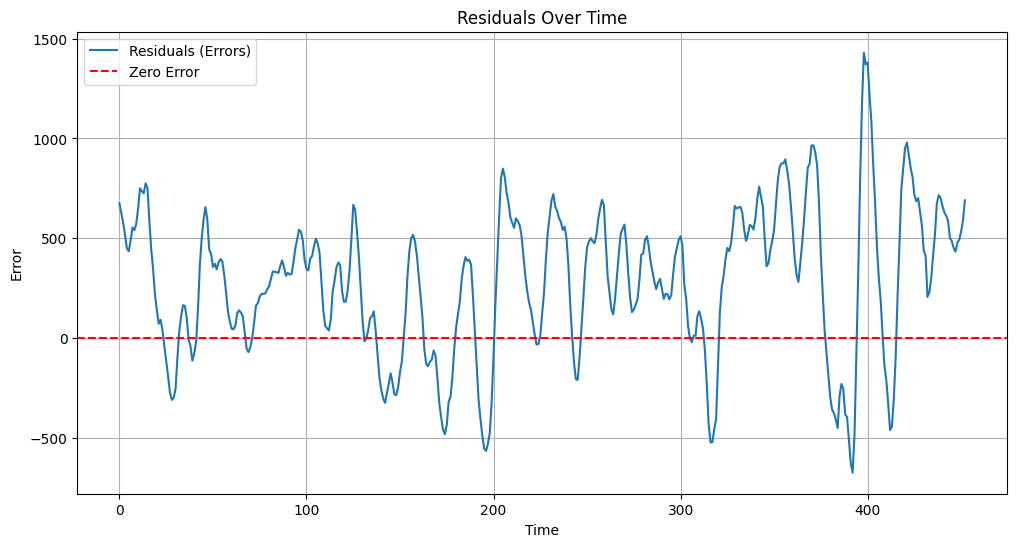

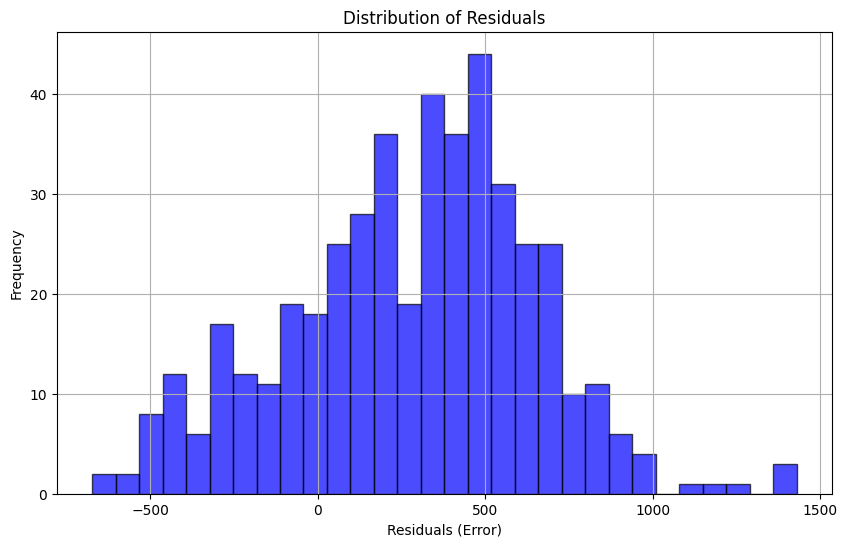

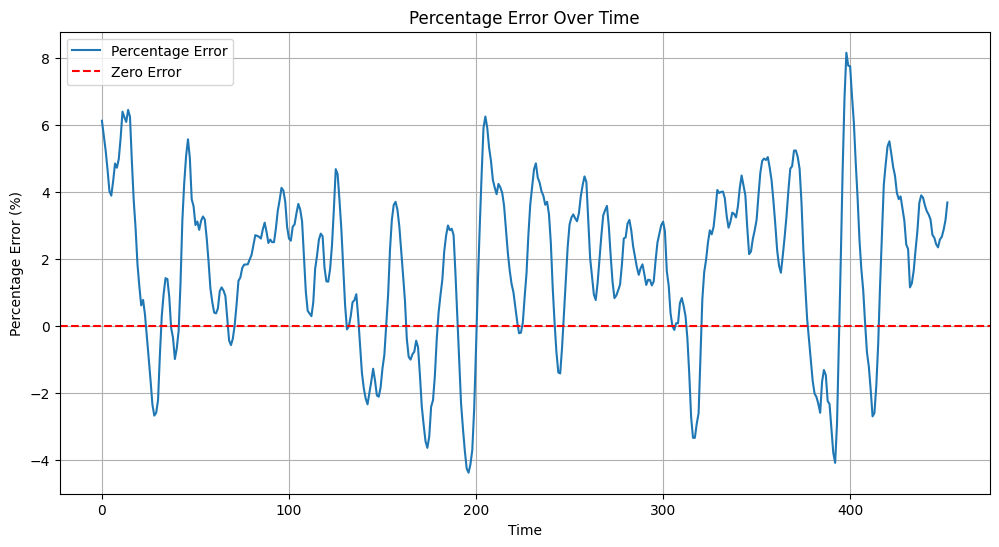

In [ ]:
# Step 1: Data Collection
nasdaq = yf.download('^IXIC', start="2023-01-01", end="2024-10-30")
uvxy = yf.download('UVXY', start="2023-01-01", end="2024-10-30")
vix = yf.download('^VIX', start="2023-01-01", end="2024-10-30")

# Flatten MultiIndex columns if present
if isinstance(nasdaq.columns, pd.MultiIndex):
    nasdaq.columns = ['_'.join(col).strip() for col in nasdaq.columns.values]
if isinstance(uvxy.columns, pd.MultiIndex):
    uvxy.columns = ['_'.join(col).strip() for col in uvxy.columns.values]
if isinstance(vix.columns, pd.MultiIndex):
    vix.columns = ['_'.join(col).strip() for col in vix.columns.values]

# Keep relevant columns and rename
nasdaq = nasdaq[['Open_^IXIC', 'High_^IXIC', 'Low_^IXIC', 'Close_^IXIC', 'Volume_^IXIC']].rename(columns={
    'Open_^IXIC': 'Open',
    'High_^IXIC': 'High',
    'Low_^IXIC': 'Low',
    'Close_^IXIC': 'Close',
    'Volume_^IXIC': 'Volume'
})
uvxy = uvxy[['Adj Close_UVXY']].rename(columns={'Adj Close_UVXY': 'UVXY_Close'})
vix = vix[['Adj Close_^VIX']].rename(columns={'Adj Close_^VIX': 'VIX_Close'})

# Merge data on date
data = nasdaq.merge(uvxy, left_index=True, right_index=True, how='inner')
data = data.merge(vix, left_index=True, right_index=True, how='inner')

# Ensure no missing values
data['Close'] = pd.to_numeric(data['Close'], errors='coerce').ffill().bfill()
data['UVXY_Close'] = pd.to_numeric(data['UVXY_Close'], errors='coerce').ffill().bfill()
data['VIX_Close'] = pd.to_numeric(data['VIX_Close'], errors='coerce').ffill().bfill()

# Step 2: Feature Engineering
# Target: Predict the average price over the next 5 days
data['Target'] = data['Close'].shift(-5).rolling(window=5, min_periods=1).mean()

# Drop rows with NaN caused by shift
data.dropna(inplace=True)

# Combined sentiment index ['Open', 'High', 'Low', 'Close', 'Volume', 'UVXY_Close', 'VIX_Close']
features_combined = ['Open', 'High', 'Low', 'Close', 'Volume', 'UVXY_Close', 'VIX_Close']
scaled_features_combined = loaded_scaler_features.transform(data[features_combined])
sequence_length = 5
x_feature, _ = create_sequences(scaled_features_combined, data['Target'], sequence_length)


# Prediction
predictions_scaled = loaded_model.predict(x_feature)
predictions_combined = loaded_scaler_target.inverse_transform(predictions_scaled)
real_price = data['Target'].values.reshape(-1, 1)

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(real_price[sequence_length-1:], label='Real Average Price')
plt.plot(predictions_combined, label='Predicted Average Price')
plt.legend()
plt.show()

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ensure no NaN values in real_price and predictions_technical
valid_indices = ~np.isnan(real_price[sequence_length:]) & ~np.isnan(predictions_combined.squeeze())

# Filter out NaN values
filtered_real_price = real_price[sequence_length:].squeeze()
filtered_predictions_combined = predictions_combined.squeeze()

# Performance Metrics
r2 = r2_score(filtered_real_price, filtered_predictions_combined)
mae = mean_absolute_error(filtered_real_price, filtered_predictions_combined)
mse = mean_squared_error(filtered_real_price, filtered_predictions_combined)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((filtered_real_price - filtered_predictions_combined)
          / filtered_real_price)) * 100

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot Residuals Over Time
residuals = filtered_real_price - filtered_predictions_combined
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals (Errors)")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# Error Distribution (Histogram)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Percentage Error Over Time
percentage_errors = (residuals / filtered_real_price) * 100
plt.figure(figsize=(12, 6))
plt.plot(percentage_errors, label="Percentage Error")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Percentage Error Over Time")
plt.xlabel("Time")
plt.ylabel("Percentage Error (%)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
loaded_model1 = load_model("model1.h5")
loaded_model2 = load_model("model2.h5")
loaded_gating_model = load_model("gating_model.h5")

# Load the scalers
with open("scaler_featureModel1.pkl", "rb") as f:
    loaded_scaler_features1 = pickle.load(f)

with open("scaler_featureModel2.pkl", "rb") as f:
    loaded_scaler_features2 = pickle.load(f)

with open("scaler_featureMOE.pkl", "rb") as f:
    loaded_scaler_features_MOE = pickle.load(f)

with open("scaler_targetMOE.pkl", "rb") as f:
    loaded_scaler_target = pickle.load(f)

print("Model and scalers loaded successfully!")

import pickle

Model and scalers loaded successfully!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² Score: 0.8937
Mean Absolute Error (MAE): 577.0779
Mean Squared Error (MSE): 460386.9922
Root Mean Squared Error (RMSE): 678.5182
Mean Absolute Percentage Error (MAPE): 15.45%
Directional Percentage of Accuracy (DPA): 56.78%


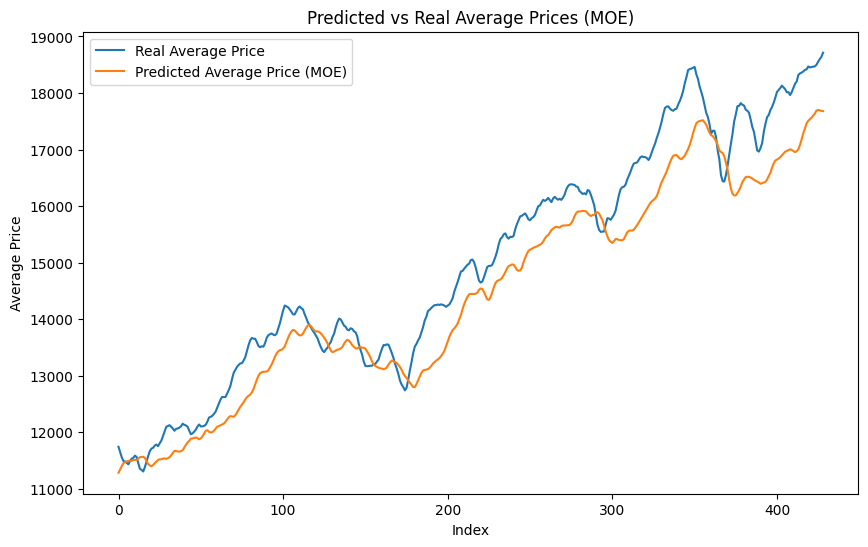

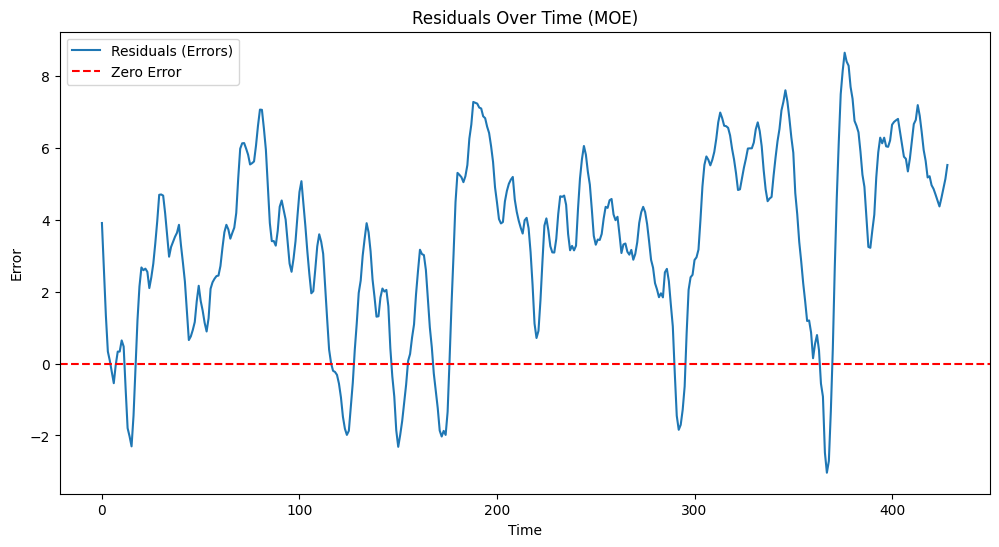

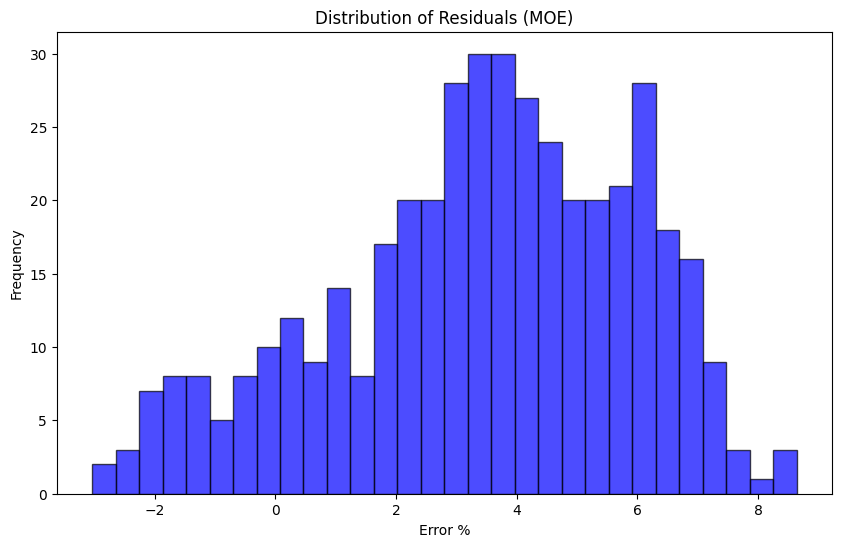

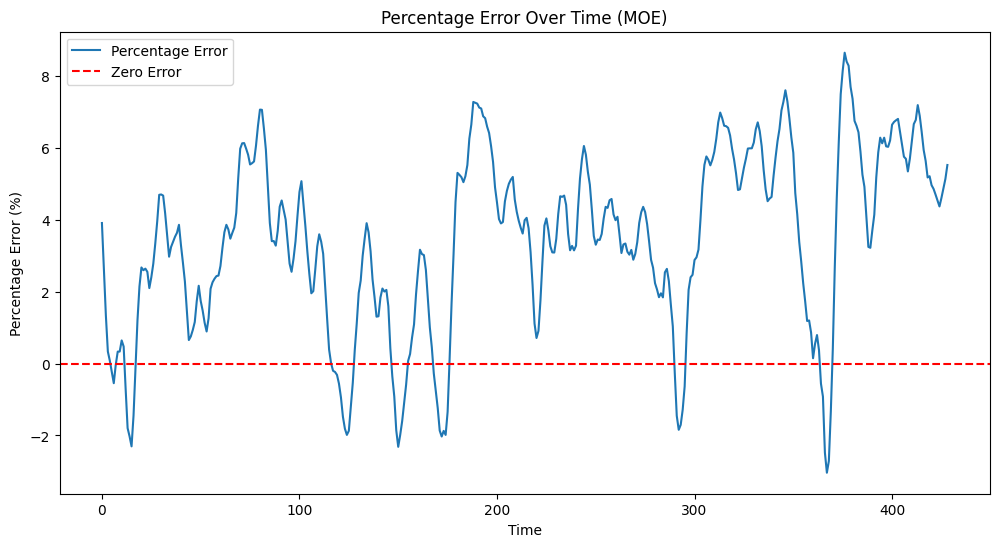

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

def create_sequences(features, target, sequence_length):
    valid_length = min(len(features), len(target)) - sequence_length
    features = features[:valid_length + sequence_length]
    target = target[:valid_length]

    X, y = [], []
    for i in range(valid_length):
        X.append(features[i:i + sequence_length])
        y.append(target[i])
    return np.array(X), np.array(y)

# Step 1: Load and Preprocess New Data
new_data = yf.download('^IXIC', start="2023-01-01", end="2024-10-30")
uvxy_new = yf.download('UVXY', start="2023-01-01", end="2024-10-30")
vix_new = yf.download('^VIX', start="2023-01-01", end="2024-10-30")

# Flatten MultiIndex columns if necessary
if isinstance(new_data.columns, pd.MultiIndex):
    new_data.columns = ['_'.join(col).strip() for col in new_data.columns.values]
if isinstance(uvxy_new.columns, pd.MultiIndex):
    uvxy_new.columns = ['_'.join(col).strip() for col in uvxy_new.columns.values]
if isinstance(vix_new.columns, pd.MultiIndex):
    vix_new.columns = ['_'.join(col).strip() for col in vix_new.columns.values]

# Select and rename relevant columns
uvxy_close_col = 'Close_UVXY' if 'Close_UVXY' in uvxy_new.columns else 'Adj Close_UVXY'
vix_close_col = 'Close_^VIX' if 'Close_^VIX' in vix_new.columns else 'Adj Close_^VIX'

uvxy_new = uvxy_new[[uvxy_close_col]].rename(columns={uvxy_close_col: 'UVXY_Close'})
vix_new = vix_new[[vix_close_col]].rename(columns={vix_close_col: 'VIX_Close'})

# Merge UVXY and VIX data with NASDAQ data
new_data = new_data.merge(uvxy_new, left_index=True, right_index=True, how='inner')
new_data = new_data.merge(vix_new, left_index=True, right_index=True, how='inner')

# Rename columns for consistency
new_data.rename(columns={
    'Open_^IXIC': 'Open',
    'High_^IXIC': 'High',
    'Low_^IXIC': 'Low',
    'Close_^IXIC': 'Close',
    'Volume_^IXIC': 'Volume'
}, inplace=True)

# Ensure no missing values
new_data['UVXY_Close'] = pd.to_numeric(new_data['UVXY_Close'], errors='coerce').ffill().bfill()
new_data['VIX_Close'] = pd.to_numeric(new_data['VIX_Close'], errors='coerce').ffill().bfill()

# Step 2: Preprocess New Data
# Scale OHLCV + UVXY + VIX features
features_ohlcv_uvxy_vix = ['Open', 'High', 'Low', 'Close', 'Volume', 'UVXY_Close', 'VIX_Close']
scaled_features_ohlcv = loaded_scaler_features1.transform(new_data[features_ohlcv_uvxy_vix])

# Calculate technical indicators for the new data
new_data['RSI'] = ta.momentum.RSIIndicator(new_data['Close'], window=14).rsi()
new_data['MACD'] = ta.trend.MACD(new_data['Close']).macd()
bollinger = ta.volatility.BollingerBands(new_data['Close'])
new_data['Bollinger_Upper'] = bollinger.bollinger_hband()
new_data['Bollinger_Lower'] = bollinger.bollinger_lband()
new_data['Volatility'] = new_data['Close'].rolling(window=20).std()

features_tech = ['RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
new_data.dropna(inplace=True)
scaled_features_tech = loaded_scaler_features2.transform(new_data[features_tech])

# Combine all features for the gating network
shared_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'UVXY_Close', 'VIX_Close',
                   'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility']
scaled_shared_features = loaded_scaler_features_MOE.transform(new_data[shared_features])

# Remove misalignment
min_length = min(len(scaled_features_ohlcv), len(scaled_features_tech), len(scaled_shared_features))
scaled_features_ohlcv = scaled_features_ohlcv[:min_length]
scaled_features_tech = scaled_features_tech[:min_length]
scaled_shared_features = scaled_shared_features[:min_length]

# Create sequences for prediction
sequence_length = 5
X_ohlcv, _ = create_sequences(scaled_features_ohlcv, np.zeros(len(scaled_features_ohlcv)), sequence_length)
X_tech, _ = create_sequences(scaled_features_tech, np.zeros(len(scaled_features_tech)), sequence_length)
X_shared, _ = create_sequences(scaled_shared_features, np.zeros(len(scaled_shared_features)), sequence_length)

# Step 3: Predict with MOE
# Predict using Model 1 and Model 2
pred1 = loaded_model1.predict(X_ohlcv)
pred2 = loaded_model2.predict(X_tech)

# Get gating network weights
gating_weights = loaded_gating_model.predict(X_shared)

# Combine predictions using gating weights
final_predictions = gating_weights[:, 0:1] * pred1 + gating_weights[:, 1:2] * pred2

# Step 4: Postprocess Predictions
# Inverse transform predictions to original scale
predictions_original = loaded_scaler_target.inverse_transform(final_predictions)

# Align the target
new_data['Target'] = new_data['Close'].shift(-5).rolling(window=5, min_periods=1).mean()
aligned_target = new_data['Target'].values[sequence_length - 1:len(predictions_original) + sequence_length - 1]

# Filter out NaN values
valid_indices = ~np.isnan(aligned_target) & ~np.isnan(predictions_original.squeeze())
filtered_real_price = aligned_target[valid_indices]
filtered_predictions_MOE = predictions_original[valid_indices]

# Performance Metrics
r2 = r2_score(filtered_real_price, filtered_predictions_MOE)
mae = mean_absolute_error(filtered_real_price, filtered_predictions_MOE)
mse = mean_squared_error(filtered_real_price, filtered_predictions_MOE)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((filtered_real_price - filtered_predictions_MOE) / filtered_real_price)) * 100

real_direction = np.sign(np.diff(filtered_real_price))  # +1 for up, -1 for down, 0 for no change
predicted_direction = np.sign(np.diff(filtered_predictions_MOE.squeeze()))  # Same for predictions

# Compare the directions
correct_directions = real_direction == predicted_direction

# Calculate Directional Percentage of Error (DPE)
dpe = np.sum(correct_directions) / len(correct_directions) * 100

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Directional Percentage of Accuracy (DPA): {dpe:.2f}%")

# Plot Real and Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(filtered_real_price, label='Real Average Price')
plt.plot(filtered_predictions_MOE, label='Predicted Average Price (MOE)')
plt.legend()
plt.title("Predicted vs Real Average Prices (MOE)")
plt.xlabel("Index")
plt.ylabel("Average Price")
plt.show()

# Plot Residuals
residuals = filtered_real_price - filtered_predictions_MOE.squeeze()
percentage_errors = (residuals / filtered_real_price) * 100
plt.figure(figsize=(12, 6))
plt.plot(percentage_errors, label="Residuals (Errors)")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Residuals Over Time (MOE)")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.show()

# Residual Distribution
plt.figure(figsize=(10, 6))
plt.hist(percentage_errors, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Residuals (MOE)")
plt.xlabel("Error %")
plt.ylabel("Frequency")
plt.show()

# Percentage Errors
percentage_errors = (residuals / filtered_real_price) * 100
plt.figure(figsize=(12, 6))
plt.plot(percentage_errors, label="Percentage Error")
plt.axhline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Percentage Error Over Time (MOE)")
plt.xlabel("Time")
plt.ylabel("Percentage Error (%)")
plt.legend()
plt.show()
